## Imports

In [38]:
import numpy as np
from matplotlib import pyplot, cm
from mpl_toolkits.mplot3d import Axes3D
import time
from numba import njit
from pyccel.epyccel import epyccel
from pyccel.decorators import types

## Pure python function

In [40]:
def solve_2d_diff_pure(u, un, nt, dt, dx, dy, nu):
    row, col = u.shape  
    u[int(.5 / dy):int(1 / dy + 1),int(.5 / dx):int(1 / dx + 1)] = 2 
    for n in range(nt + 1):
        # boundaries condition are included here since the initial vector is ones() 
        # and they're not changed anymore
        un[1:-1,1:-1] = u[1:-1,1:-1] 
        for j in range(2, row):
            for i in range(2, col):
                u[j-1, i-1] = (un[j-1, i-1] + nu * dt / dx**2 * (un[j-1, i] - 2 * un[j-1, i-1] + un[j-1,i-2])\
                               + nu * dt / dy**2 * (un[j, i-1] - 2 * un[j-1, i-1] + un[j-2,i-1])) 
    return 0

## Numba accelerator

In [41]:
@njit(fastmath=True)
def solve_2d_diff_numba(u, un, nt, dt, dx, dy, nu):
    row, col = u.shape  
    u[int(.5 / dy):int(1 / dy + 1),int(.5 / dx):int(1 / dx + 1)] = 2 
    for n in range(nt + 1):
        # boundaries condition are included here since the initial vector is ones() 
        # and they're not changed anymore
        un[1:-1,1:-1] = u[1:-1,1:-1]
        for j in range(2, row):
            for i in range(2, col):
                u[j-1, i-1] = (un[j-1, i-1] + nu * dt / dx**2 * (un[j-1, i] - 2 * un[j-1, i-1] + un[j-1,i-2])\
                               + nu * dt / dy**2 * (un[j, i-1] - 2 * un[j-1, i-1] + un[j-2,i-1])) 
        
    return 0

## Pyccel accelerator

In [42]:
def solve_2d_diff_pyccel(u:'float[:,:]', un:'float[:,:]', nt:'int', dt:'float', dx:'float', dy:'float', nu:'float'):
    row, col = u.shape  
    u[int(.5 / dy):int(1 / dy + 1),int(.5 / dx):int(1 / dx + 1)] = 2 
    for n in range(nt + 1):
        # boundaries condition are included here since the initial vector is ones() 
        # and they're not changed anymore
        un[1:-1,1:-1] = u[1:-1,1:-1]
        for j in range(2, row):
            for i in range(2, col):
                u[j-1, i-1] = (un[j-1, i-1] + nu * dt / dx**2 * (un[j-1, i] - 2 * un[j-1, i-1] + un[j-1,i-2])+ nu * dt / dy**2 * (un[j, i-1] - 2 * un[j-1, i-1] + un[j-2,i-1])) 
        
    return 0

## Inputs

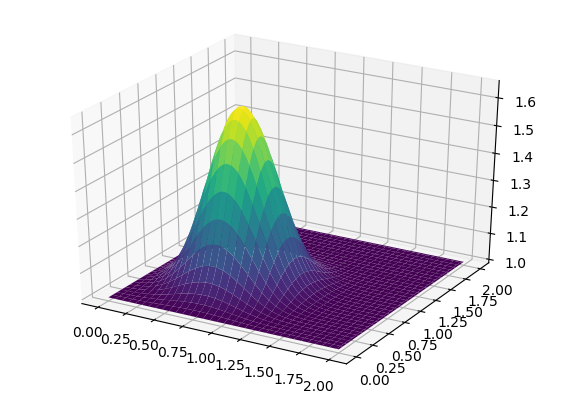

In [52]:
###variable declarations
nt = 200
nx = 101
ny = 101
nu = .05
dx = 2 / (nx - 1)
dy = 2 / (ny - 1)
sigma = .25
dt = sigma * dx * dy / nu

x = np.linspace(0, 2, nx)
y = np.linspace(0, 2, ny)

u = np.ones((ny, nx))  # create a 1xn vector of 1's
un = np.ones((ny, nx))

solve_2d_diff_pure(u, un, nt, dt, dx, dy, nu)

fig = pyplot.figure(figsize=(7, 5), dpi=100)
ax = fig.gca(projection='3d')                      
X, Y = np.meshgrid(x, y)                            
surf = ax.plot_surface(X, Y, u, cmap=cm.viridis)

## Call Funtions

### Pure function

In [53]:
%timeit solve_2d_diff_pure(u, un, nt, dt, dx, dy, nu)

6.24 s ± 272 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Function with numba accelerator

In [54]:
%timeit solve_2d_diff_numba(u, un, nt, dt, dx, dy, nu)

8.41 ms ± 91.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### Function with pyccel accelerator

In [55]:
solve_2d_diff_f90 = epyccel(solve_2d_diff_pyccel)

In [56]:
%timeit solve_2d_diff_f90(u, un, nt, dt, dx, dy, nu)

2.99 ms ± 43.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
